<a href="https://colab.research.google.com/github/anisetusms/DASI_DALIS_Kelompok_06/blob/main/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Prediksi Peluang Obesitas pada Siswa SMA/SMK di Toba dan Tapanuli Utara Berdasarkan Pola Hidup Menggunakan Machine Learning
"""
# 1. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, classification_report, confusion_matrix,
                            roc_curve, roc_auc_score, auc)
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print("✓ Semua libraries berhasil dimuat!")

✓ Semua libraries berhasil dimuat!


In [ ]:
# ==========================================
# 1. LOAD DATA
# ==========================================
print("\n" + "="*70)
print("TAHAP 1: PENGUMPULAN & LOADING DATA")
print("="*70)

df = pd.read_csv("data_siswa-siswi1.csv", sep=';', encoding='latin1')
print(f"✓ Data berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")

# Tampilkan semua kolom
print("\nDaftar Kolom:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

# Drop kolom yang completely empty
df = df.dropna(axis=1, how="all")
print(f"\n✓ Kolom kosong dihapus: Sisa {df.shape[1]} kolom")


TAHAP 1: PENGUMPULAN & LOADING DATA
✓ Data berhasil dimuat: 2050 baris, 27 kolom

Daftar Kolom:
  1. Timestamp
  2. Nama lengkap
  3. Jenis Kelamin
  4. Usia
  5. Jalur Pendidikan
  6. Asal Sekolah
  7. Kelas
  8.  Berapa berat badan kamu sekarang? (dalam kilogram)  
  9. Berapa tinggi badan kamu sekarang? (dalam centimeter)
  10. Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari? 
  11. Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?  
  12. Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji
  13. Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?
  14. Secara umum, jenis makanan apa yang paling sering kamu konsumsi?  
  15. Berapa kali kamu berolahraga dalam seminggu?
  16. Jika kamu berolahraga, rata-rata berapa menit durasi tiap kali olahraga?  
  17. Seberapa sering kamu dalam melakukan aktivitas fisik s

In [ ]:
# ==========================================
# 2. DATA CLEANING & PREPROCESSING
# ==========================================
print("\n" + "="*70)
print("TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA (STANDARDIZED)")
print("="*70)

# 2.1 Fungsi untuk membersihkan angka dengan satuan
def clean_numeric(val):
    """Membersihkan nilai numerik dengan satuan (kg, cm, tahun)"""
    if pd.isna(val):
        return np.nan
    val = str(val).lower()
    for unit in ["kg", "cm", "tahun", "th", "jam", "kilogram", "centimeter"]:
        val = val.replace(unit, "")
    val = val.replace(",", ".").strip()
    try:
        return float(val)
    except:
        return np.nan



TAHAP 2: PEMBERSIHAN & PREPROCESSING DATA (STANDARDIZED)


In [ ]:
# 2.2 Mapping kategori → nilai numerik (STANDARDIZED)
mapping_tidur = {"< 5 jam": 4, "5-6 jam": 5.5, "5–6 jam": 5.5, "7-8 jam": 7.5, "7–8 jam": 7.5, "> 8 jam": 9}
mapping_makan = {"1 kali": 1, "2 kali": 2, "3 kali": 3, "> 3 kali": 4}
mapping_jajan = {"0 - 2 kali": 1, "3 - 5 kali": 4, "4 - 5 kali": 4.5, "6 - 10 kali": 8, "> 10 kali": 12, "> 10  kali": 12}
mapping_fastfood = {"0 - 2 kali": 1, "3 -  5 kali": 4, "3 - 5 kali": 4, "> 5 kali": 7}
mapping_minuman = {"0 - 2 gelas": 1, "3 - 5 gelas": 4, "6 - 10 gelas": 8, "10 - 6 gelas": 8, "10 gelas": 8, ">10 gelas": 12, "> 10 gelas": 12}

mapping_makan_malam = {
    "0 Kali": 0,
    "0 kali": 0,
    "1 Kali": 1,
    "1 kali": 1,
    "2 - 3 kali": 2.5,
    "2 - 3 Kali": 2.5,
    "4 kali": 4, # Added this entry
    "5 Kali": 5,
    "> 4 kali": 6,
}

In [ ]:
# 2.3 Bersihkan kolom numerik dasar
df["berat_kg"] = df[" Berapa berat badan kamu sekarang? (dalam kilogram)  "].apply(clean_numeric)
df["tinggi_cm"] = df["Berapa tinggi badan kamu sekarang? (dalam centimeter)"].apply(clean_numeric)
df["usia_tahun"] = df["Usia"].apply(clean_numeric)
print("✓ Kolom numerik (berat, tinggi, usia) dibersihkan")


✓ Kolom numerik (berat, tinggi, usia) dibersihkan


In [ ]:
# 2.4 Mapping kategori frekuensi makan/minum
df["durasi_tidur_jam"] = (df["Rata-rata, berapa jam kamu tidur setiap malam?  "]
                          .astype(str).str.strip()
                          .str.replace(r'[-—\x96]', '–', regex=True) # Normalize various dashes to en-dash
                          .str.replace(r'\s*–\s*', '–', regex=True) # Remove spaces around en-dash
                          .str.replace(r'\s+', ' ', regex=True) # Normalize multiple spaces to single space
                          .replace(mapping_tidur).astype(float))
df["makan_per_hari"] = (df["Dalam 7 hari terakhir, rata-rata kamu makan utama (pagi/siang/malam) berapa kali per hari? "]
                        .astype(str).str.strip().replace(mapping_makan).astype(float))
df["jajan_per_minggu"] = (df["Dalam 7 hari terakhir, kira-kira berapa kali kamu jajan (di luar makan utama)?  "]
                          .astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
                          .replace(mapping_jajan).astype(float))
df["fastfood_per_minggu"] = (df["Dalam 7 hari terakhir, berapa kali kamu makan fast food / makanan cepat saji"]
                             .astype(str).str.strip().replace(mapping_fastfood).astype(float))
df["minuman_manis_per_minggu"] = (df["Dalam 7 hari terakhir, berapa gelas/porsi minuman manis (teh manis, minuman bersoda, boba, minuman serbuk manis) yang kamu konsumsi?"]
                                  .astype(str).str.strip().str.replace('> 10 gelas', '>10 gelas', regex=False)
                                  .replace(mapping_minuman).astype(float))
print("✓ Mapping kategori frekuensi makan/minum selesai")

# ==========================================
# ==========================================
print("\n" + "-"*50)
print("PROCESSING 3 FITUR BARU:")
print("-"*50)

# Fitur Baru 1: Makan setelah jam 21.00
col_makan_malam = "Dalam 7 hari terakhir, berapa kali Anda mengonsumsi makanan utama atau cemilan setelah pukul 21.00? "
if col_makan_malam in df.columns:
    df["makan_setelah_21"] = (df[col_makan_malam]
                              .astype(str).str.strip()
                              .replace(mapping_makan_malam).astype(float))
    print(f"✓ Fitur 1: makan_setelah_21 - berhasil diproses")
    print(f"  Distribusi: {df['makan_setelah_21'].value_counts().to_dict()}")
else:
    # Coba cari kolom dengan nama mirip
    for col in df.columns:
        if "setelah pukul 21" in col.lower() or "setelah jam 21" in col.lower():
            df["makan_setelah_21"] = (df[col]
                                      .astype(str).str.strip()
                                      .replace(mapping_makan_malam).astype(float))
            print(f"✓ Fitur 1: makan_setelah_21 - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["makan_setelah_21"] = np.nan
        print("⚠ Fitur 1: makan_setelah_21 - kolom tidak ditemukan, diisi NaN")

# Fitur Baru 2: Aktivitas fisik harian (versi baru dengan "naik & turun tangga")
col_aktivitas_new = "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik & turun tangga, kegiatan di rumah/sekolah)?"
if col_aktivitas_new in df.columns:
    df["aktivitas_fisik_harian_new"] = pd.to_numeric(df[col_aktivitas_new], errors='coerce')
    print(f"✓ Fitur 2: aktivitas_fisik_harian_new - berhasil diproses")
    print(f"  Distribusi: {df['aktivitas_fisik_harian_new'].value_counts().to_dict()}")
else:
    # Coba cari kolom dengan nama mirip
    for col in df.columns:
        if "naik & turun tangga" in col.lower():
            df["aktivitas_fisik_harian_new"] = pd.to_numeric(df[col], errors='coerce')
            print(f"✓ Fitur 2: aktivitas_fisik_harian_new - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["aktivitas_fisik_harian_new"] = np.nan
        print("⚠ Fitur 2: aktivitas_fisik_harian_new - kolom tidak ditemukan, diisi NaN")

# Fitur Baru 3: Makan akibat stres
col_makan_stres = "Dalam 7 hari terakhir, seberapa sering Anda mengonsumsi makanan akibat perasaan stres?  "
if col_makan_stres in df.columns:
    df["makan_karena_stres"] = pd.to_numeric(df[col_makan_stres], errors='coerce')
    print(f"✓ Fitur 3: makan_karena_stres - berhasil diproses")
    print(f"  Distribusi: {df['makan_karena_stres'].value_counts().to_dict()}")
else:
    # Coba cari kolom dengan nama mirip
    for col in df.columns:
        if "makanan akibat perasaan stres" in col.lower() or "makan akibat stres" in col.lower():
            df["makan_karena_stres"] = pd.to_numeric(df[col], errors='coerce')
            print(f"✓ Fitur 3: makan_karena_stres - berhasil diproses dari kolom: {col[:50]}...")
            break
    else:
        df["makan_karena_stres"] = np.nan
        print("⚠ Fitur 3: makan_karena_stres - kolom tidak ditemukan, diisi NaN")

print("-"*50)

✓ Mapping kategori frekuensi makan/minum selesai

--------------------------------------------------
PROCESSING 3 FITUR BARU:
--------------------------------------------------
✓ Fitur 1: makan_setelah_21 - berhasil diproses
  Distribusi: {1.0: 791, 0.0: 545, 2.5: 539, 6.0: 130, 4.0: 25, 5.0: 20}
✓ Fitur 2: aktivitas_fisik_harian_new - berhasil diproses
  Distribusi: {4: 756, 5: 488, 3: 472, 2: 281, 1: 53}
✓ Fitur 3: makan_karena_stres - berhasil diproses
  Distribusi: {2: 610, 1: 565, 3: 468, 4: 265, 5: 142}
--------------------------------------------------


In [ ]:

# 2.5 Handle outlier BMI & tinggi badan SEBELUM imputasi
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)

df.loc[df['BMI'] > 50, 'BMI'] = np.nan  # BMI > 50 unrealistic untuk siswa
mask_potential_meters = (df["tinggi_cm"] >= 1.0) & (df["tinggi_cm"] <= 2.5)
df.loc[mask_potential_meters, "tinggi_cm"] *= 100
df.loc[(df["tinggi_cm"] < 100) | (df["tinggi_cm"] > 200), "tinggi_cm"] = np.nan
print("✓ Outlier dihapus/disesuaikan")


✓ Outlier dihapus/disesuaikan


In [ ]:

# 2.6 STANDARDIZED Imputasi MEDIAN untuk kolom numerik - UPDATED dengan fitur baru
imputer = SimpleImputer(strategy='median')
kolom_imputasi = [
    'berat_kg', 'tinggi_cm', 'usia_tahun', 'durasi_tidur_jam',
    'makan_per_hari', 'jajan_per_minggu', 'fastfood_per_minggu',
    'minuman_manis_per_minggu',
    'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres'
]

for kolom in kolom_imputasi:
    if kolom in df.columns:
        df[kolom] = imputer.fit_transform(df[[kolom]])[:, 0]

# Hitung ulang tinggi meter dan BMI setelah imputasi
df['tinggi_meter'] = df['tinggi_cm'] / 100
df['BMI'] = df['berat_kg'] / (df['tinggi_meter'] ** 2)

# Imputasi BMI dengan median
imputer_bmi = SimpleImputer(strategy='median')
df['BMI'] = imputer_bmi.fit_transform(df[['BMI']])[:, 0]

print("✓ Median imputasi untuk kolom numerik selesai (termasuk 3 fitur baru)")



✓ Median imputasi untuk kolom numerik selesai (termasuk 3 fitur baru)


In [ ]:
# ==========================================
# 3. FEATURE ENGINEERING & ENCODING
# ==========================================
print("\n" + "="*70)
print("TAHAP 3: FEATURE ENGINEERING & ENCODING (STANDARDIZED)")
print("="*70)

# 3.1 Kategorisasi BMI
def bmi_category(bmi):
    """Kategorisasi BMI berdasarkan standar WHO"""
    if bmi < 18.5:
        return "Kurus"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obesitas"

df["kategori_BMI"] = df["BMI"].apply(bmi_category)
df["label_obesitas"] = df["kategori_BMI"].apply(lambda x: 1 if x == "Obesitas" else 0)
print("✓ Kategorisasi BMI & label obesitas dibuat")
print(f"  Class distribution: {df['label_obesitas'].value_counts().to_dict()}")



TAHAP 3: FEATURE ENGINEERING & ENCODING (STANDARDIZED)
✓ Kategorisasi BMI & label obesitas dibuat
  Class distribution: {0: 1998, 1: 52}


In [ ]:

# 3.2 Encoding kolom kategorikal STANDARDIZED
df["keluarga_obesitas"] = df["Apakah ada keluarga Anda yang pernah atau sedang mengalami obesitas?"].apply(
    lambda x: 1 if str(x).strip().lower() == "iya" else 0)
df["jenis_kelamin"] = df["Jenis Kelamin"].apply(
    lambda x: 1 if str(x).strip().lower() == "laki-laki" else 0)
print("✓ Encoding keluarga obesitas & jenis kelamin selesai")


✓ Encoding keluarga obesitas & jenis kelamin selesai


In [ ]:

# 3.3 Rename kolom panjang (kolom lama - untuk backward compatibility)
df.rename(columns={
    "Seberapa sering kamu dalam melakukan aktivitas fisik sehari-hari (jalan kaki, naik turun tangga, kegiatan di rumah/sekolah)?  ": "aktivitas_fisik",
    "Seberapa sering kamu merasa stres (karena tugas, sekolah, keluarga, dsb)?  ": "tingkat_stres",
    "Seberapa besar pengaruh teman terhadap kebiasaan kamu jajan/makan (misalnya diajak nongkrong, makan bersama)?  ": "pengaruh_teman"
}, inplace=True)
print("✓ Nama kolom diperpendek")


✓ Nama kolom diperpendek


In [ ]:

# 3.4 Simpan dataset bersih
df.to_csv("dataset_bersih_final.csv", index=False)
print("✓ Dataset bersih disimpan ke: dataset_bersih_final.csv")


✓ Dataset bersih disimpan ke: dataset_bersih_final.csv



TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)

STATISTIK DESKRIPTIF:
        usia_tahun     berat_kg    tinggi_cm          BMI  makan_per_hari  \
count  2050.000000  2050.000000  2050.000000  2050.000000     2050.000000   
mean     16.152195    53.875566   159.174380    21.251282        2.813659   
std       0.955454    11.004193     8.142077     3.945066        0.550441   
min      14.000000    22.000000   115.000000     8.579027        1.000000   
25%      15.000000    48.000000   154.000000    19.051974        3.000000   
50%      16.000000    52.000000   159.000000    20.700817        3.000000   
75%      17.000000    58.000000   165.000000    22.656250        3.000000   
max      19.000000   167.000000   190.000000    61.839393        4.000000   

       jajan_per_minggu  minuman_manis_per_minggu  durasi_tidur_jam  \
count       2050.000000               2050.000000       2050.000000   
mean           3.976341                  2.565854          6.723171   
std            2.910584     

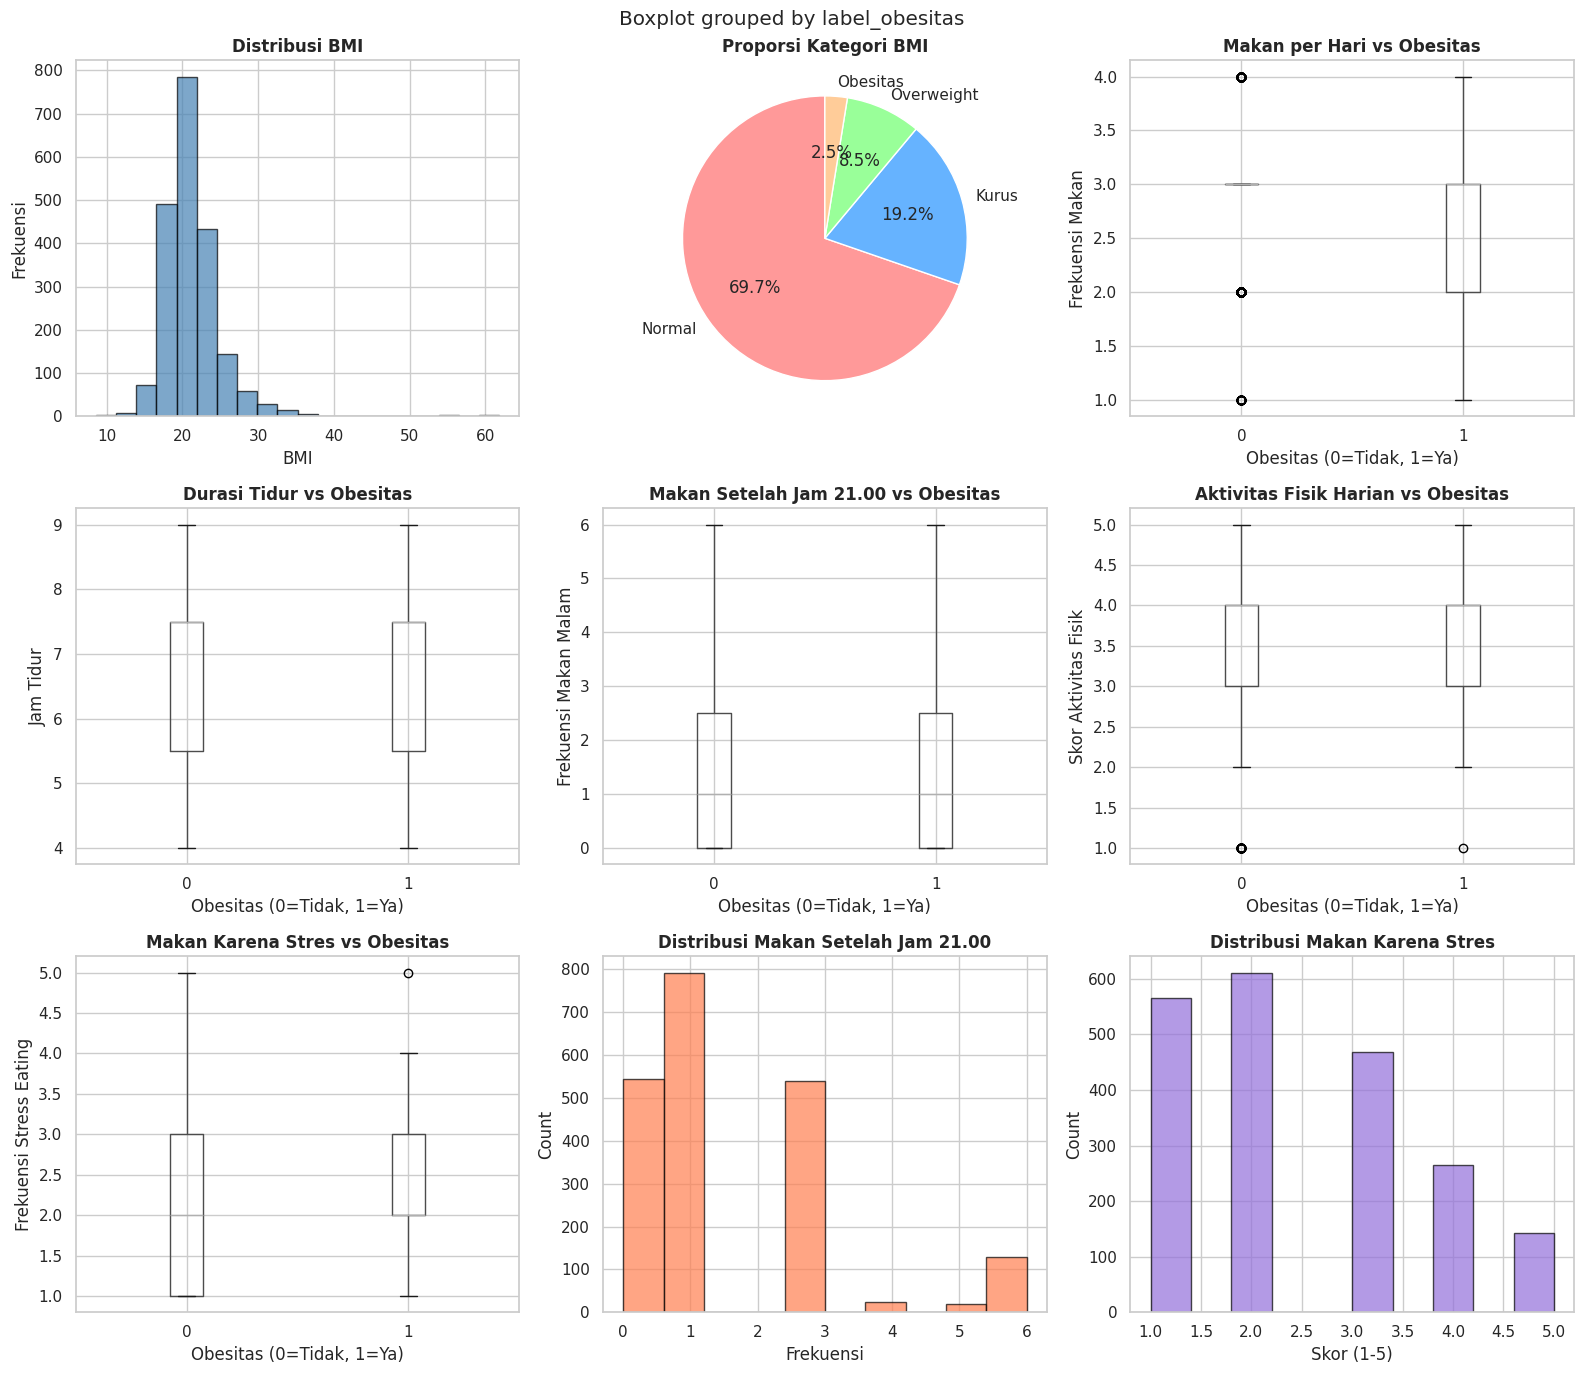

✓ Visualisasi EDA disimpan: eda_overview_v2.png


In [ ]:
# ==========================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
print("\n" + "="*70)
print("TAHAP 4: EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\nSTATISTIK DESKRIPTIF:")
desc_cols = ['usia_tahun', 'berat_kg', 'tinggi_cm', 'BMI', 'makan_per_hari',
             'jajan_per_minggu', 'minuman_manis_per_minggu', 'durasi_tidur_jam',
             'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres']
print(df[[c for c in desc_cols if c in df.columns]].describe())

# Visualisasi
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle("Exploratory Data Analysis - Distribusi Utama & Fitur Baru", fontsize=16, fontweight='bold')

# Row 1
axes[0,0].hist(df["BMI"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title("Distribusi BMI", fontweight='bold')
axes[0,0].set_xlabel("BMI")
axes[0,0].set_ylabel("Frekuensi")

bmi_counts = df["kategori_BMI"].value_counts()
axes[0,1].pie(bmi_counts, labels=bmi_counts.index, autopct='%1.1f%%', startangle=90,
              colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0,1].set_title("Proporsi Kategori BMI", fontweight='bold')

df.boxplot(column='makan_per_hari', by='label_obesitas', ax=axes[0,2])
axes[0,2].set_title("Makan per Hari vs Obesitas", fontweight='bold')
axes[0,2].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[0,2].set_ylabel("Frekuensi Makan")

# Row 2
df.boxplot(column='durasi_tidur_jam', by='label_obesitas', ax=axes[1,0])
axes[1,0].set_title("Durasi Tidur vs Obesitas", fontweight='bold')
axes[1,0].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
axes[1,0].set_ylabel("Jam Tidur")

if 'makan_setelah_21' in df.columns:
    df.boxplot(column='makan_setelah_21', by='label_obesitas', ax=axes[1,1])
    axes[1,1].set_title("Makan Setelah Jam 21.00 vs Obesitas", fontweight='bold')
    axes[1,1].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[1,1].set_ylabel("Frekuensi Makan Malam")

if 'aktivitas_fisik_harian_new' in df.columns:
    df.boxplot(column='aktivitas_fisik_harian_new', by='label_obesitas', ax=axes[1,2])
    axes[1,2].set_title("Aktivitas Fisik Harian vs Obesitas", fontweight='bold')
    axes[1,2].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[1,2].set_ylabel("Skor Aktivitas Fisik")

# Row 3
if 'makan_karena_stres' in df.columns:
    df.boxplot(column='makan_karena_stres', by='label_obesitas', ax=axes[2,0])
    axes[2,0].set_title("Makan Karena Stres vs Obesitas", fontweight='bold')
    axes[2,0].set_xlabel("Obesitas (0=Tidak, 1=Ya)")
    axes[2,0].set_ylabel("Frekuensi Stress Eating")

# Distribusi 3 fitur baru
if 'makan_setelah_21' in df.columns:
    axes[2,1].hist(df['makan_setelah_21'].dropna(), bins=10, color='coral', edgecolor='black', alpha=0.7)
    axes[2,1].set_title("Distribusi Makan Setelah Jam 21.00", fontweight='bold')
    axes[2,1].set_xlabel("Frekuensi")
    axes[2,1].set_ylabel("Count")

if 'makan_karena_stres' in df.columns:
    axes[2,2].hist(df['makan_karena_stres'].dropna(), bins=10, color='mediumpurple', edgecolor='black', alpha=0.7)
    axes[2,2].set_title("Distribusi Makan Karena Stres", fontweight='bold')
    axes[2,2].set_xlabel("Skor (1-5)")
    axes[2,2].set_ylabel("Count")

# Korelasi dengan BMI
print("\n" + "-"*60)
print("KORELASI DENGAN BMI:")
print("-"*60)
numeric_df = df.select_dtypes(include=[np.number])
corr_bmi = numeric_df.corr()["BMI"].sort_values(ascending=False)
print(corr_bmi.head(10))

plt.tight_layout()
plt.savefig("eda_overview_v2.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Visualisasi EDA disimpan: eda_overview_v2.png")



In [ ]:
# ==========================================
# 5. PREPARE DATA FOR ML
# ==========================================
print("\n" + "="*70)
print("TAHAP 5: ML PREPROCESSING ")
print("="*70)


TAHAP 5: ML PREPROCESSING 


In [ ]:

# 5.1 Pilih fitur
features = [
    "usia_tahun",
    "jenis_kelamin",
    "makan_per_hari",
    "minuman_manis_per_minggu",
    "fastfood_per_minggu",
    "jajan_per_minggu",
    "aktivitas_fisik",
    "durasi_tidur_jam",
    "tingkat_stres",
    "pengaruh_teman",
    "keluarga_obesitas",
    "makan_setelah_21",
    "aktivitas_fisik_harian_new",
    "makan_karena_stres"
]

# Filter fitur yang ada di dataframe
available_features = [f for f in features if f in df.columns]
print(f" Fitur tersedia: {len(available_features)} dari {len(features)} features")
print(f"  Fitur yang digunakan: {available_features}")

missing_features = [f for f in features if f not in df.columns]
if missing_features:
    print(f" Fitur tidak ditemukan: {missing_features}")

X = df[available_features]
y = df["label_obesitas"]

print(f"\n Shape X: {X.shape}")
print(f"  Target distribution: {y.value_counts().to_dict()}")


 Fitur tersedia: 14 dari 14 features
  Fitur yang digunakan: ['usia_tahun', 'jenis_kelamin', 'makan_per_hari', 'minuman_manis_per_minggu', 'fastfood_per_minggu', 'jajan_per_minggu', 'aktivitas_fisik', 'durasi_tidur_jam', 'tingkat_stres', 'pengaruh_teman', 'keluarga_obesitas', 'makan_setelah_21', 'aktivitas_fisik_harian_new', 'makan_karena_stres']

 Shape X: (2050, 14)
  Target distribution: {0: 1998, 1: 52}


In [ ]:
# 5.2 Train-test split dengan stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f" Data split: train={X_train.shape[0]}, test={X_test.shape[0]}")


 Data split: train=1640, test=410


In [ ]:
# 5.3 Imputasi SEBELUM scaling
imputer_ml = SimpleImputer(strategy='median')
X_train_imputed = imputer_ml.fit_transform(X_train)
X_test_imputed = imputer_ml.transform(X_test)
print(" Missing values diimputasi dengan median")


 Missing values diimputasi dengan median


In [ ]:
# 5.4 STANDARDIZED Scaling SEBELUM SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)
print(" Feature scaling dengan StandardScaler")


 Feature scaling dengan StandardScaler


In [ ]:
# 5.5 SMOTE untuk balance data
try:
    sm = SMOTE(random_state=42, k_neighbors=min(5, y_train.sum()-1))
    X_train_sm, y_train_sm = sm.fit_resample(X_train_scaled, y_train)
    print(f" SMOTE applied:")
    print(f"  - Sebelum: Obesity={y_train.sum()}, Non-Obesity={len(y_train)-y_train.sum()}")
    print(f"  - Sesudah: Obesity={y_train_sm.sum()}, Non-Obesity={len(y_train_sm)-y_train_sm.sum()}")
except Exception as e:
    print(f" SMOTE gagal: {e}")
    print("  Menggunakan data asli tanpa oversampling")
    X_train_sm, y_train_sm = X_train_scaled, y_train


 SMOTE applied:
  - Sebelum: Obesity=42, Non-Obesity=1598
  - Sesudah: Obesity=1598, Non-Obesity=1598


In [ ]:
# ==========================================
# 6. MODEL TRAINING
# ==========================================
print("\n" + "="*70)
print("TAHAP 6: TRAINING MODEL")
print("="*70)

print("\n[1/2] Training Logistic Regression...")
logreg = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs',
    C=1.0
)
logreg.fit(X_train_sm, y_train_sm)
y_pred_logreg = logreg.predict(X_test_scaled)
y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
print("Logistic Regression training selesai")

print("[2/2] Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=12,
    random_state=42,
    class_weight='balanced',
    min_samples_split=10,
    min_samples_leaf=5
)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
print("Random Forest training selesai")



TAHAP 6: TRAINING MODEL

[1/2] Training Logistic Regression...
Logistic Regression training selesai
[2/2] Training Random Forest...
Random Forest training selesai


In [ ]:
# ==========================================
# 7. OPTIMAL THRESHOLD TUNING
# ==========================================
print("\n" + "="*70)
print("TAHAP 7: OPTIMAL THRESHOLD TUNING")
print("="*70)

def find_optimal_threshold(y_true, y_prob):
    """Cari threshold optimal menggunakan Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[best_idx]
    return optimal_threshold

threshold_lr = find_optimal_threshold(y_test, y_prob_logreg)
threshold_rf = find_optimal_threshold(y_test, y_prob_rf)

print(f"Optimal Threshold - Logistic Regression: {threshold_lr:.4f}")
print(f"Optimal Threshold - Random Forest: {threshold_rf:.4f}")

# Apply optimal threshold
y_pred_logreg_opt = (y_prob_logreg >= threshold_lr).astype(int)
y_pred_rf_opt = (y_prob_rf >= threshold_rf).astype(int)



TAHAP 7: OPTIMAL THRESHOLD TUNING
Optimal Threshold - Logistic Regression: 0.2493
Optimal Threshold - Random Forest: 0.0334


In [ ]:
# ==========================================
# 8. MODEL EVALUATION
# ==========================================
print("\n" + "="*70)
print("TAHAP 8: EVALUASI MODEL - DEFAULT vs OPTIMAL THRESHOLD")
print("="*70)

def evaluate_model(title, y_true, y_pred, y_prob):
    """Fungsi untuk evaluasi model"""
    print(f"\n{title}")
    print("-" * 60)
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")
    try:
        auc_val = roc_auc_score(y_true, y_prob)
        print(f"AUC-ROC:   {auc_val:.4f}")
    except:
        auc_val = 0
        print(f"AUC-ROC:   N/A (insufficient classes)")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Obesity', 'Obesity'], zero_division=0))
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, zero_division=0)

# Evaluasi dengan default threshold
print("\n🔵 DEFAULT THRESHOLD (0.5):")
acc_lr_def, f1_lr_def = evaluate_model("LOGISTIC REGRESSION", y_test, y_pred_logreg, y_prob_logreg)
acc_rf_def, f1_rf_def = evaluate_model("RANDOM FOREST", y_test, y_pred_rf, y_prob_rf)

# Evaluasi dengan optimal threshold
print("\n\n🟢 OPTIMAL THRESHOLD:")
acc_lr_opt, f1_lr_opt = evaluate_model("LOGISTIC REGRESSION (Optimal)", y_test, y_pred_logreg_opt, y_prob_logreg)
acc_rf_opt, f1_rf_opt = evaluate_model("RANDOM FOREST (Optimal)", y_test, y_pred_rf_opt, y_prob_rf)



TAHAP 8: EVALUASI MODEL - DEFAULT vs OPTIMAL THRESHOLD

🔵 DEFAULT THRESHOLD (0.5):

LOGISTIC REGRESSION
------------------------------------------------------------
Accuracy:  0.7171
Precision: 0.0431
Recall:    0.5000
F1-Score:  0.0794
AUC-ROC:   0.6635

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.98      0.72      0.83       400
     Obesity       0.04      0.50      0.08        10

    accuracy                           0.72       410
   macro avg       0.51      0.61      0.46       410
weighted avg       0.96      0.72      0.81       410


RANDOM FOREST
------------------------------------------------------------
Accuracy:  0.9634
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
AUC-ROC:   0.6997

Classification Report:
              precision    recall  f1-score   support

 Non-Obesity       0.98      0.99      0.98       400
     Obesity       0.00      0.00      0.00        10

    accuracy                           


TAHAP 9: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE


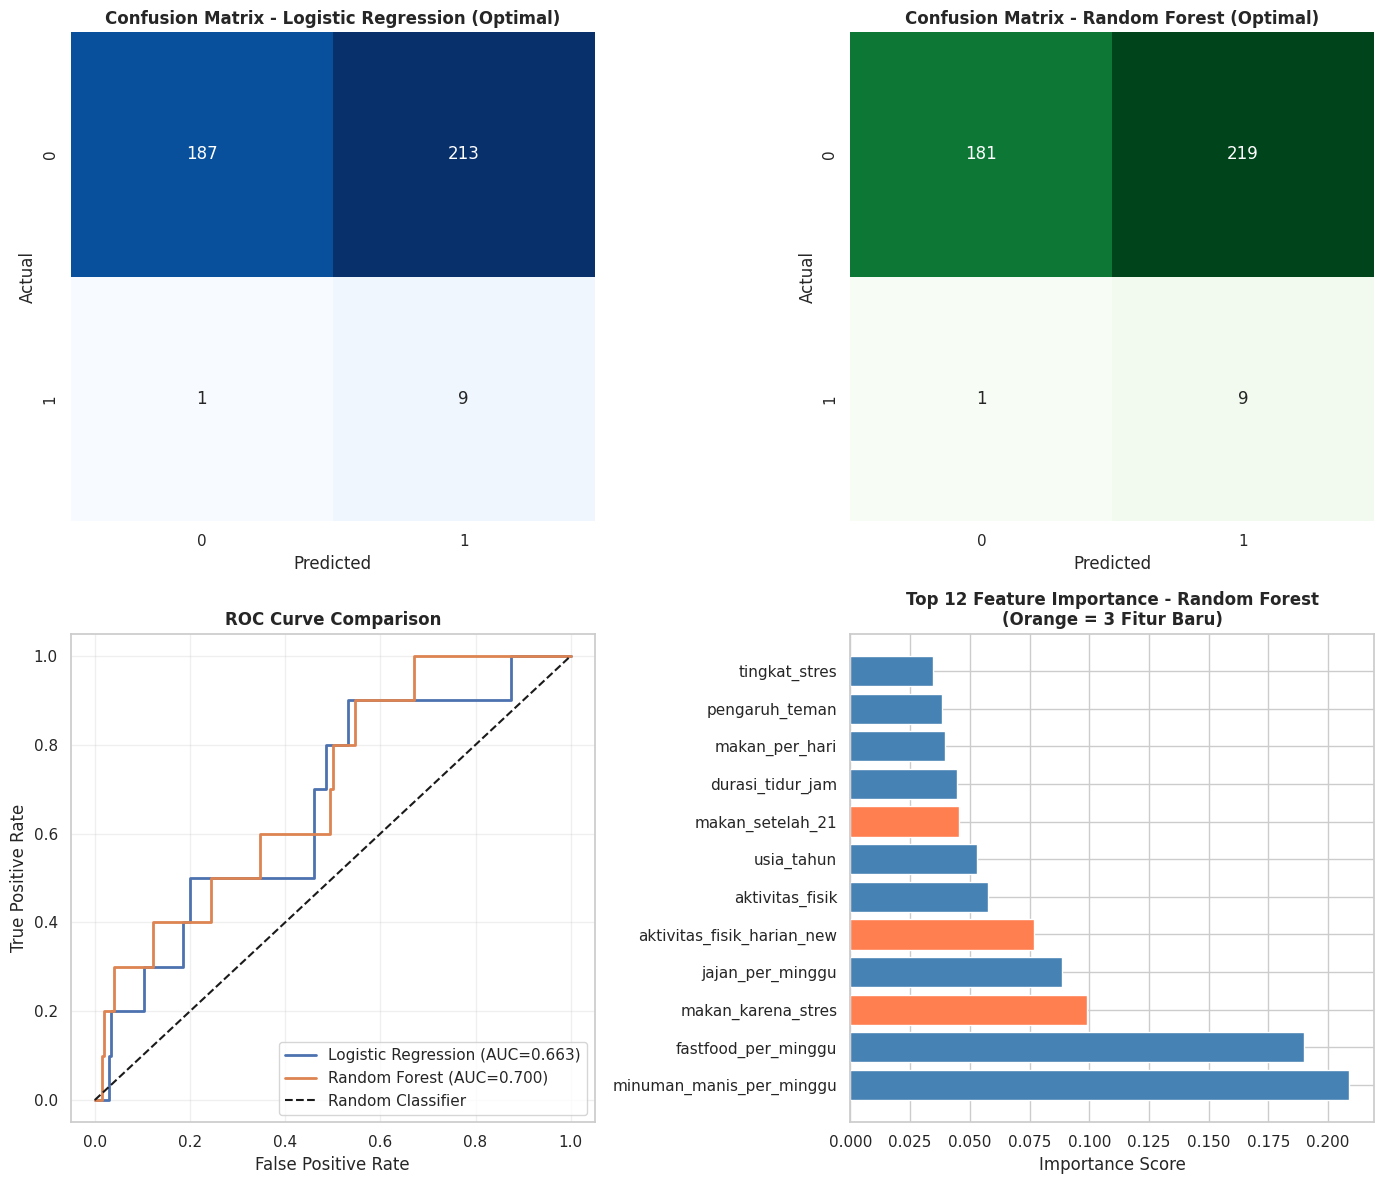

✓ Evaluasi model disimpan: model_evaluation_v2.png


In [ ]:
# ==========================================
# 9. CONFUSION MATRIX & FEATURE IMPORTANCE
# ==========================================
print("\n" + "="*70)
print("TAHAP 9: VISUALISASI CONFUSION MATRIX & FEATURE IMPORTANCE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

cm_lr = confusion_matrix(y_test, y_pred_logreg_opt)
cm_rf = confusion_matrix(y_test, y_pred_rf_opt)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], cbar=False)
axes[0, 0].set_title("Confusion Matrix - Logistic Regression (Optimal)", fontweight='bold')
axes[0, 0].set_ylabel("Actual")
axes[0, 0].set_xlabel("Predicted")

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1], cbar=False)
axes[0, 1].set_title("Confusion Matrix - Random Forest (Optimal)", fontweight='bold')
axes[0, 1].set_ylabel("Actual")
axes[0, 1].set_xlabel("Predicted")

# ROC Curve
try:
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_logreg)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
    auc_lr = roc_auc_score(y_test, y_prob_logreg)
    auc_rf = roc_auc_score(y_test, y_prob_rf)

    axes[1, 0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', linewidth=2)
    axes[1, 0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    axes[1, 0].set_xlabel("False Positive Rate")
    axes[1, 0].set_ylabel("True Positive Rate")
    axes[1, 0].set_title("ROC Curve Comparison", fontweight='bold')
    axes[1, 0].legend(loc='lower right')
    axes[1, 0].grid(alpha=0.3)
except Exception as e:
    axes[1, 0].text(0.5, 0.5, f"ROC Curve unavailable\n{e}", ha='center', va='center')
    auc_lr, auc_rf = 0, 0

# Feature Importance - UPDATED dengan fitur baru
feat_importance = pd.Series(rf.feature_importances_, index=available_features).sort_values(ascending=False)
colors = ['coral' if 'makan_setelah_21' in f or 'aktivitas_fisik_harian_new' in f or 'makan_karena_stres' in f
          else 'steelblue' for f in feat_importance.index[:12]]
axes[1, 1].barh(feat_importance.index[:12], feat_importance.values[:12], color=colors)
axes[1, 1].set_xlabel("Importance Score")
axes[1, 1].set_title("Top 12 Feature Importance - Random Forest\n(Orange = 3 Fitur Baru)", fontweight='bold')

plt.tight_layout()
plt.savefig("model_evaluation_v2.png", dpi=300, bbox_inches='tight')
plt.show()
print("✓ Evaluasi model disimpan: model_evaluation_v2.png")


In [ ]:
# ==========================================
# 11. KESIMPULAN & REKOMENDASI
# ==========================================
print("\n" + "="*70)
print("TAHAP 11: KESIMPULAN & REKOMENDASI")
print("="*70)

best_model = "Random Forest" if f1_rf_opt > f1_lr_opt else "Logistic Regression"
best_f1 = max(f1_rf_opt, f1_lr_opt)

insights = f"""
SUMMARY ANALISIS OBESITAS SISWA (VERSI TERBARU DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: {df.shape[0]}
   - Persentase obesitas: {df['label_obesitas'].mean()*100:.2f}%
   - Rata-rata BMI: {df['BMI'].mean():.2f}
   - Jumlah fitur: {len(available_features)} (termasuk 3 fitur baru)

2. KATEGORI BMI DISTRIBUTION:
{df['kategori_BMI'].value_counts(normalize=True).mul(100).round(2)}

3. 3 FITUR BARU YANG DITAMBAHKAN:
   ✓ makan_setelah_21: Frekuensi makan setelah jam 21.00
   ✓ aktivitas_fisik_harian_new: Aktivitas fisik (jalan kaki, naik & turun tangga)
   ✓ makan_karena_stres: Frekuensi makan akibat stres

4. FAKTOR PALING BERPENGARUH (TOP 10):
{chr(10).join([f"   {i+1}. {feat}: {imp:.4f}" for i, (feat, imp) in enumerate(feat_importance.head(10).items())])}

5. BEST MODEL PERFORMANCE (Optimal Threshold):
   - Model: {best_model}
   - Accuracy: {max(acc_lr_opt, acc_rf_opt):.4f}
   - F1-Score: {best_f1:.4f}
   - AUC-ROC: {max(auc_lr, auc_rf):.4f}
   - Threshold: {threshold_rf if best_model == 'Random Forest' else threshold_lr:.4f}

6. REKOMENDASI KESEHATAN:
   a) Hindari makan setelah jam 21.00 (late-night eating)
   b) Tingkatkan aktivitas fisik harian (jalan kaki, naik turun tangga)
   c) Kelola stres dengan baik (hindari emotional eating)
   d) Kurangi konsumsi minuman manis
   e) Tidur 7-8 jam setiap malam
   f) Batasi fast food (<2 kali/minggu)
"""
print(insights)



TAHAP 11: KESIMPULAN & REKOMENDASI

SUMMARY ANALISIS OBESITAS SISWA (VERSI TERBARU DENGAN 3 FITUR BARU):

1. DATA OVERVIEW:
   - Total siswa: 2050
   - Persentase obesitas: 2.54%
   - Rata-rata BMI: 21.25
   - Jumlah fitur: 14 (termasuk 3 fitur baru)

2. KATEGORI BMI DISTRIBUTION:
kategori_BMI
Normal        69.71
Kurus         19.22
Overweight     8.54
Obesitas       2.54
Name: proportion, dtype: float64

3. 3 FITUR BARU YANG DITAMBAHKAN:
   ✓ makan_setelah_21: Frekuensi makan setelah jam 21.00
   ✓ aktivitas_fisik_harian_new: Aktivitas fisik (jalan kaki, naik & turun tangga)
   ✓ makan_karena_stres: Frekuensi makan akibat stres

4. FAKTOR PALING BERPENGARUH (TOP 10):
   1. minuman_manis_per_minggu: 0.2089
   2. fastfood_per_minggu: 0.1898
   3. makan_karena_stres: 0.0989
   4. jajan_per_minggu: 0.0887
   5. aktivitas_fisik_harian_new: 0.0768
   6. aktivitas_fisik: 0.0576
   7. usia_tahun: 0.0531
   8. makan_setelah_21: 0.0455
   9. durasi_tidur_jam: 0.0445
   10. makan_per_hari: 0.03

In [ ]:
# ==========================================
# 12. SAVE MODELS & ARTIFACTS
# ==========================================
print("\n" + "="*70)
print("TAHAP 12: MENYIMPAN MODEL & ARTIFACTS")
print("="*70)

model_data = {
    'logreg': logreg,
    'rf': rf,
    'scaler': scaler,
    'imputer': imputer_ml,
    'features': available_features,
    'threshold_lr': threshold_lr,
    'threshold_rf': threshold_rf,
    'feature_importance': feat_importance.to_dict()
}

with open("model_data_v2.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("✓ Semua model dan artifacts berhasil disimpan!")
print("  - model_data_v2.pkl")



TAHAP 12: MENYIMPAN MODEL & ARTIFACTS
✓ Semua model dan artifacts berhasil disimpan!
  - model_data_v2.pkl


In [ ]:
# ==========================================
# 13. TEST PREDIKSI REALTIME
# ==========================================
print("\n" + "="*70)
print("TEST PREDIKSI REALTIME - DENGAN 3 FITUR BARU")
print("="*70)

def predict_obesity(usia, jenis_kelamin, makan, minuman_manis, fastfood, jajan,
                   aktivitas, tidur, stres, teman, keluarga_obesitas,
                   makan_setelah_21=2, aktivitas_fisik_baru=3, makan_karena_stres=2):
    """Prediksi risiko obesitas dengan kedua model - UPDATED dengan 3 fitur baru"""

    jk_encode = 1 if jenis_kelamin.lower() == "laki-laki" else 0
    keluarga_encode = 1 if keluarga_obesitas.lower() == "iya" else 0

    data_dict = {
        'usia_tahun': usia,
        'jenis_kelamin': jk_encode,
        'makan_per_hari': makan,
        'minuman_manis_per_minggu': minuman_manis,
        'fastfood_per_minggu': fastfood,
        'jajan_per_minggu': jajan,
        'aktivitas_fisik': aktivitas,
        'durasi_tidur_jam': tidur,
        'tingkat_stres': stres,
        'pengaruh_teman': teman,
        'keluarga_obesitas': keluarga_encode,
        'makan_setelah_21': makan_setelah_21,
        'aktivitas_fisik_harian_new': aktivitas_fisik_baru,
        'makan_karena_stres': makan_karena_stres
    }

    # Hanya gunakan fitur yang tersedia
    data_values = [data_dict[f] for f in available_features]
    data = pd.DataFrame([data_values], columns=available_features)

    data_scaled = scaler.transform(data)

    # Prediksi dari kedua model
    prob_lr = logreg.predict_proba(data_scaled)[0][1]
    prob_rf = rf.predict_proba(data_scaled)[0][1]

    # Prediksi dengan optimal threshold
    pred_lr = "OBESITAS" if prob_lr >= threshold_lr else "TIDAK OBESITAS"
    pred_rf = "OBESITAS" if prob_rf >= threshold_rf else "TIDAK OBESITAS"

    # Ensemble: rata-rata probabilitas
    prob_ensemble = (prob_lr + prob_rf) / 2
    pred_ensemble = "OBESITAS" if prob_ensemble >= 0.5 else "TIDAK OBESITAS"

    return {
        'prob_lr': prob_lr * 100,
        'pred_lr': pred_lr,
        'prob_rf': prob_rf * 100,
        'pred_rf': pred_rf,
        'prob_ensemble': prob_ensemble * 100,
        'pred_ensemble': pred_ensemble
    }

# Test prediksi
print("\n🧪 CONTOH PREDIKSI:")
print("-" * 60)

# Contoh 1: Siswa dengan kebiasaan buruk
result1 = predict_obesity(
    usia=16,
    jenis_kelamin="Laki-laki",
    makan=4,  # >3 kali
    minuman_manis=8,  # 6-10 gelas
    fastfood=4,  # 3-5 kali
    jajan=8,  # 6-10 kali
    aktivitas=2,  # Jarang
    tidur=4,  # <5 jam
    stres=4,  # Tinggi
    teman=5,  # Sangat tinggi pengaruh
    keluarga_obesitas="Iya",
    makan_setelah_21=5,  # >4 kali (BARU)
    aktivitas_fisik_baru=2,  # Rendah (BARU)
    makan_karena_stres=4  # Sering (BARU)
)
print("Contoh 1 - Siswa dengan kebiasaan KURANG SEHAT:")
print(f"  Logistic Regression: {result1['pred_lr']} ({result1['prob_lr']:.1f}%)")
print(f"  Random Forest: {result1['pred_rf']} ({result1['prob_rf']:.1f}%)")
print(f"  Ensemble: {result1['pred_ensemble']} ({result1['prob_ensemble']:.1f}%)")

# Contoh 2: Siswa dengan kebiasaan sehat
result2 = predict_obesity(
    usia=16,
    jenis_kelamin="Perempuan",
    makan=3,  # 3 kali
    minuman_manis=1,  # 0-2 gelas
    fastfood=1,  # 0-2 kali
    jajan=1,  # 0-2 kali
    aktivitas=4,  # Sering
    tidur=7.5,  # 7-8 jam
    stres=2,  # Rendah
    teman=2,  # Rendah pengaruh
    keluarga_obesitas="Tidak",
    makan_setelah_21=0,  # 0 kali (BARU)
    aktivitas_fisik_baru=5,  # Sangat tinggi (BARU)
    makan_karena_stres=1  # Sangat jarang (BARU)
)
print("\nContoh 2 - Siswa dengan kebiasaan SEHAT:")
print(f"  Logistic Regression: {result2['pred_lr']} ({result2['prob_lr']:.1f}%)")
print(f"  Random Forest: {result2['pred_rf']} ({result2['prob_rf']:.1f}%)")
print(f"  Ensemble: {result2['pred_ensemble']} ({result2['prob_ensemble']:.1f}%)")

print("\n" + "="*70)
print("ANALISIS SELESAI! ✅")
print("="*70)
print("File yang dihasilkan:")
print("  1. dataset_bersih_final.csv - Dataset yang sudah diproses")
print("  2. eda_overview_v2.png - Visualisasi EDA")
print("  3. model_evaluation_v2.png - Evaluasi model")
print("  4. model_data_v2.pkl - Model dan artifacts untuk deployment")



TEST PREDIKSI REALTIME - DENGAN 3 FITUR BARU

🧪 CONTOH PREDIKSI:
------------------------------------------------------------
Contoh 1 - Siswa dengan kebiasaan KURANG SEHAT:
  Logistic Regression: OBESITAS (84.5%)
  Random Forest: OBESITAS (33.1%)
  Ensemble: OBESITAS (58.8%)

Contoh 2 - Siswa dengan kebiasaan SEHAT:
  Logistic Regression: TIDAK OBESITAS (13.8%)
  Random Forest: TIDAK OBESITAS (0.2%)
  Ensemble: TIDAK OBESITAS (7.0%)

ANALISIS SELESAI! ✅
File yang dihasilkan:
  1. dataset_bersih_final.csv - Dataset yang sudah diproses
  2. eda_overview_v2.png - Visualisasi EDA
  3. model_evaluation_v2.png - Evaluasi model
  4. model_data_v2.pkl - Model dan artifacts untuk deployment
